In [1]:
!git clone https://github.com/v-like-engine/segmentuki

Cloning into 'segmentuki'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 90 (delta 34), reused 63 (delta 17), pack-reused 0
Receiving objects: 100% (90/90), 2.59 MiB | 30.78 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
import sys
sys.path.append("segmentuki")
from models.pix2pixHD.pix2pixHD_model import Pix2PixHD
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

In [3]:
class ADEDataset(Dataset):

    def __init__(self, root_path):
        self.img_path = root_path / "images/training"
        self.mask_path = root_path / "annotations/training"

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128, 128))
        ])
        self.img_list = sorted(self._get_filenames(self.img_path))
        self.mask_list = sorted(self._get_filenames(self.mask_path))
        
        self._read_imgs()
        self._read_masks()
        
    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        return self.transform(img).float(), self.transform(mask).float()

    def __len__(self):
        return len(self.img_list)

    def _get_filenames(self, path):
        return [f for f in path.iterdir() if f.is_file()]

    def _read_imgs(self):
        self.images = [cv2.imread(str(f)) for f in self.img_list]

    def _read_masks(self):
        self.masks = [cv2.imread(str(f)) for f in self.mask_list]

In [4]:
input_dir = "/kaggle/input/ade20k-outdoors"
dataset = ADEDataset(Path(input_dir))

In [5]:
batch_size = 8
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

In [22]:
def visualize_batch(images, masks, epoch=-1, size=2):
    fig, axs = plt.subplots(size, 2, figsize=(10, 10))
    for i in range(0, size):
        image = images[i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        
        mask = masks[i].cpu().numpy()
        mask = mask.transpose((1, 2, 0))
        mask = (mask * 255.0).astype("uint8")
        axs[i, 0].imshow(image)
        axs[i, 1].imshow(mask)
        axs[i, 0].axis("off")
        axs[i, 1].axis("off")
    plt.title(f"Epoch: {epoch}")
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


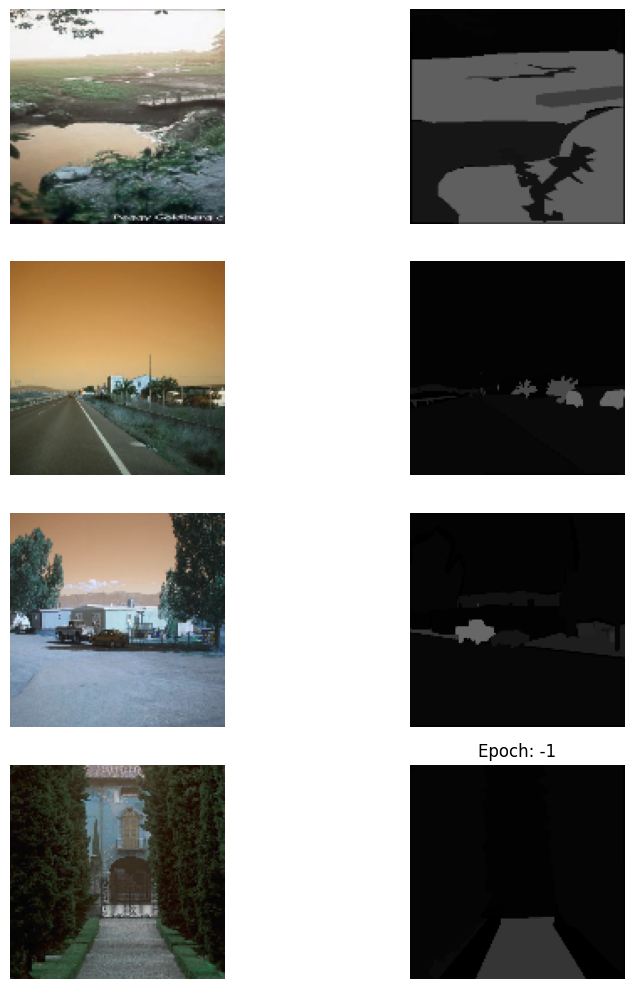

In [7]:
batch = next(iter(data_loader))
visualize_batch(batch[0], batch[1], size=4)

In [8]:
model = Pix2PixHD(device='cuda')

In [9]:
import wandb

wandb.init()

wandb.watch(model, log_freq=100)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[]

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/30 [00:07<?, ?it/s, Generator loss = 0.852109432220459 | Discriminator loss = 0.6255956292152405]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias 

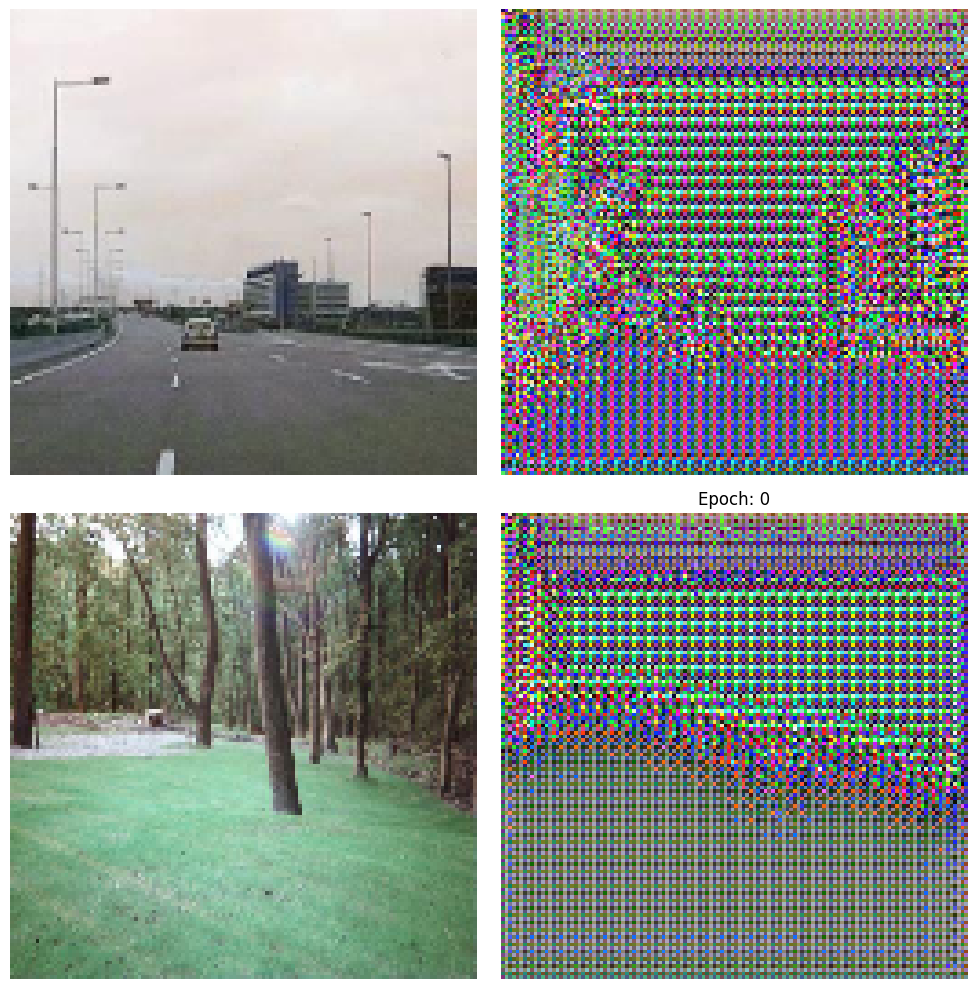

 17%|█▋        | 5/30 [12:36<52:23, 125.74s/it, Generator loss = 6.7897796630859375 | Discriminator loss = 0.04360037297010422]    

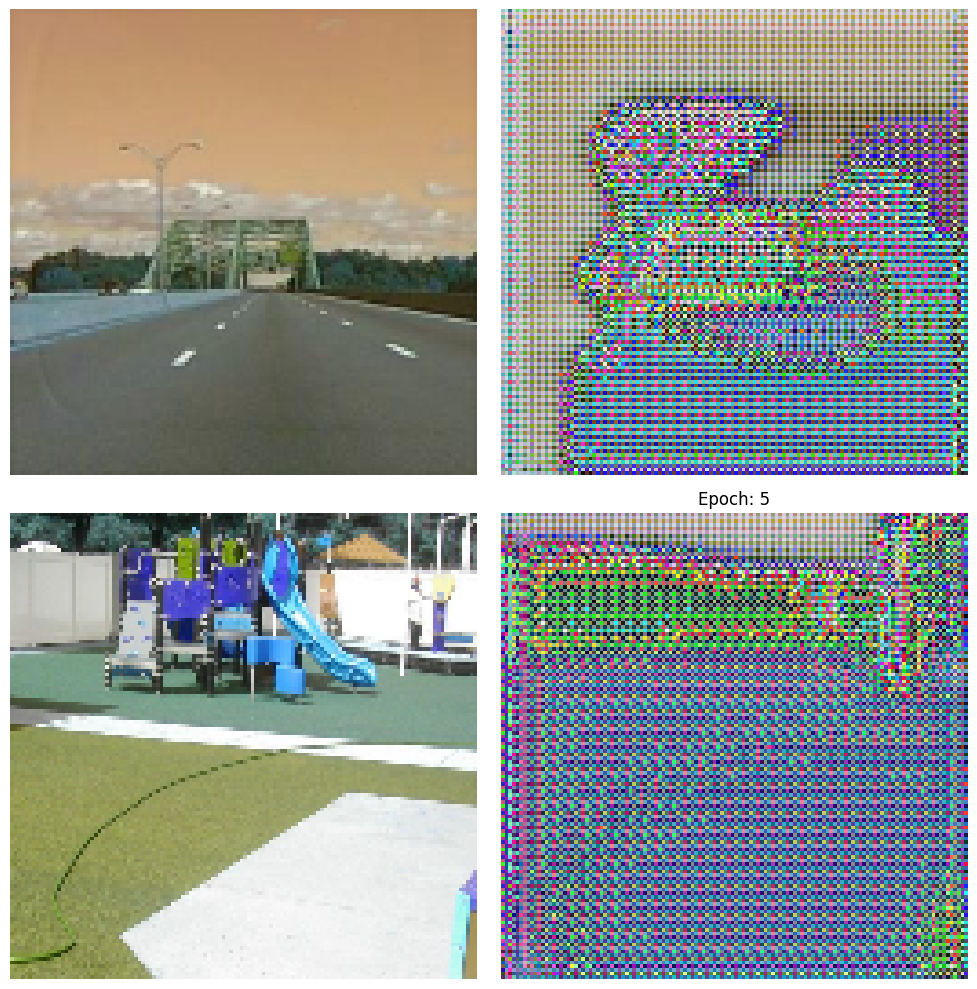

 33%|███▎      | 10/30 [23:02<41:45, 125.29s/it, Generator loss = 5.440685749053955 | Discriminator loss = 0.10214371234178543] 

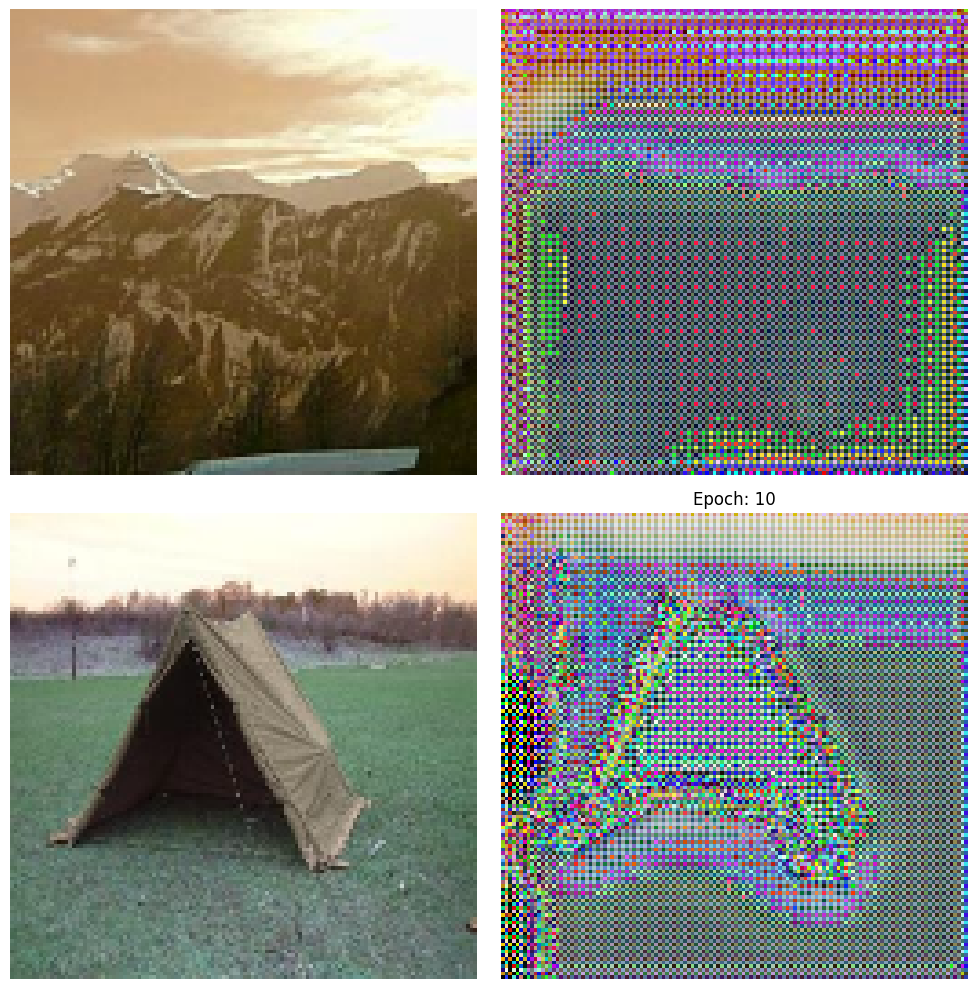

 50%|█████     | 15/30 [33:28<31:18, 125.25s/it, Generator loss = 5.238889217376709 | Discriminator loss = 0.13219153881072998]  

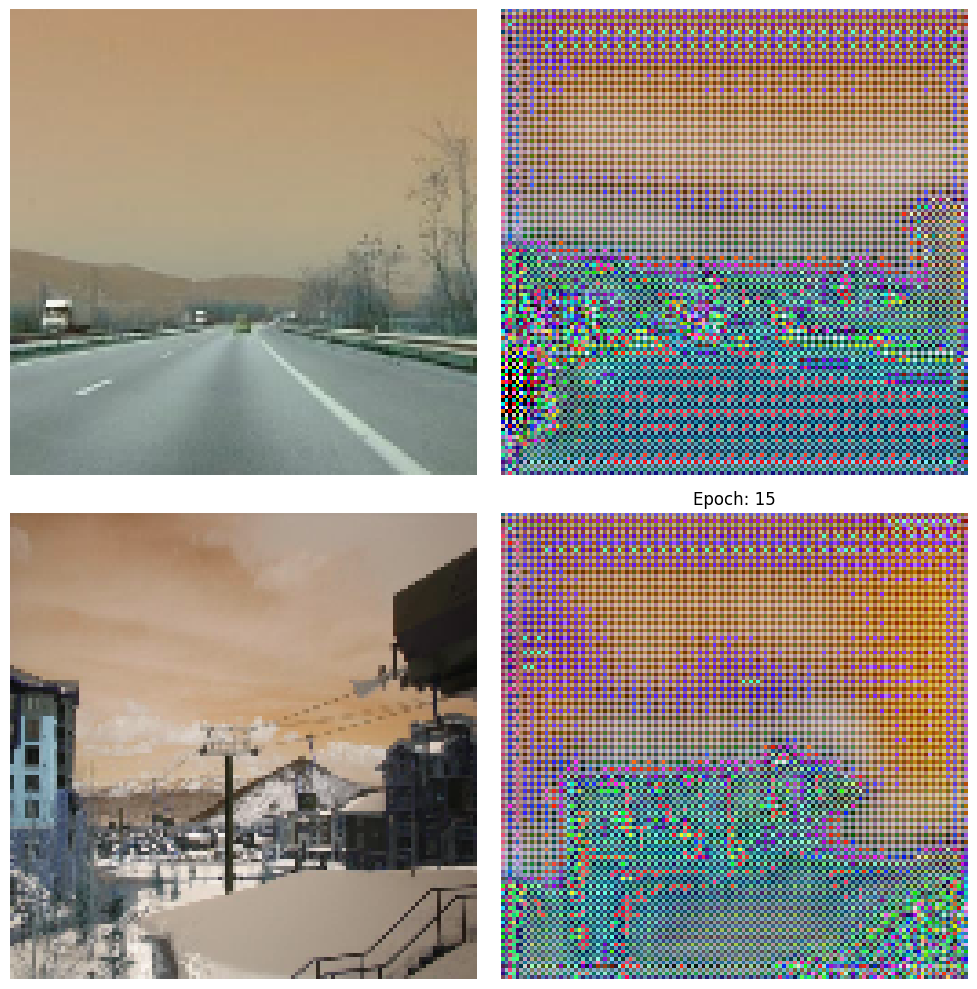

 67%|██████▋   | 20/30 [43:54<20:52, 125.24s/it, Generator loss = 5.233859539031982 | Discriminator loss = 0.07327556610107422]  

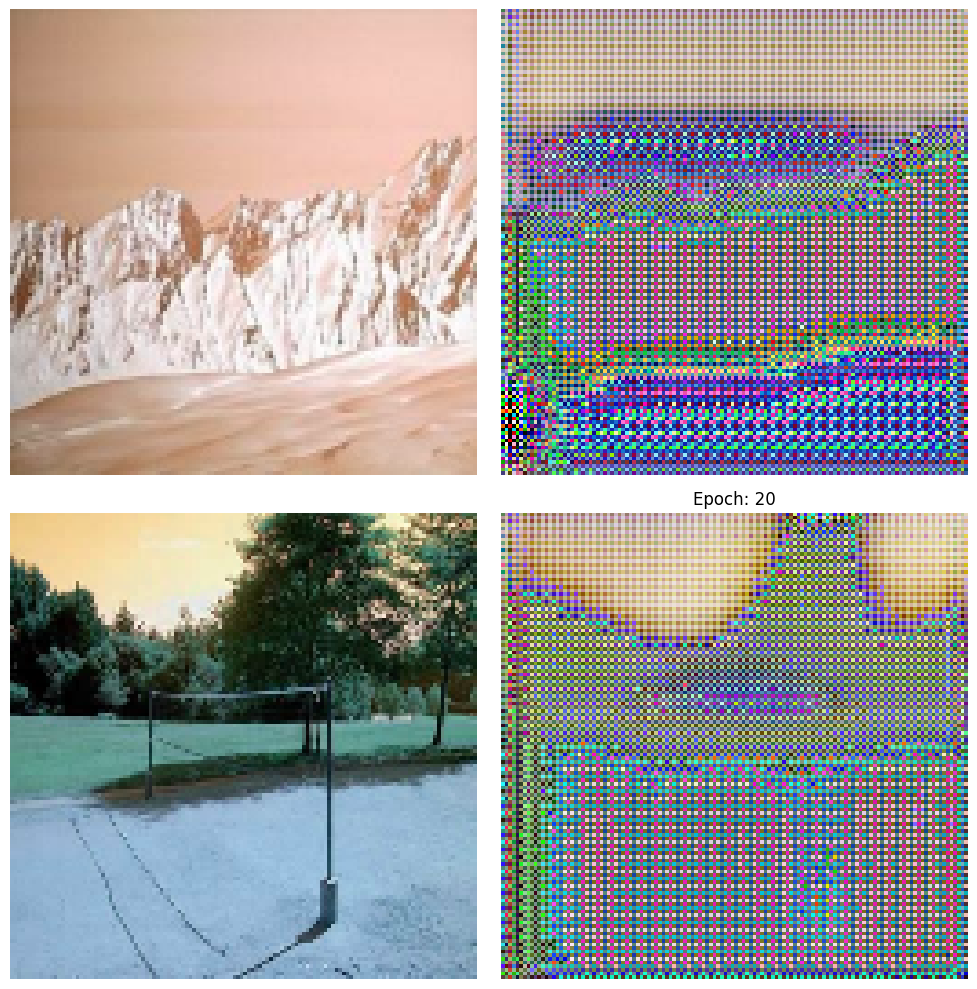

 83%|████████▎ | 25/30 [54:21<10:26, 125.23s/it, Generator loss = 4.982170581817627 | Discriminator loss = 0.11587709188461304]  

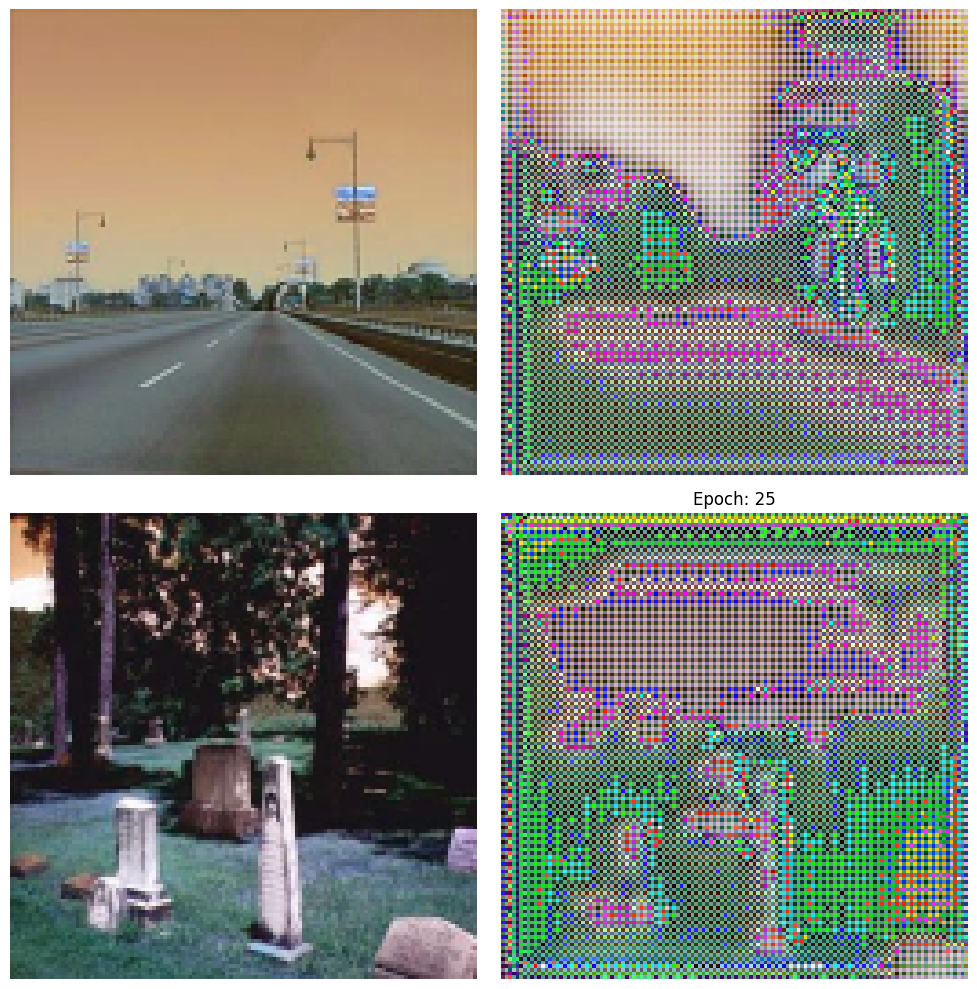

100%|██████████| 30/30 [1:02:43<00:00, 125.45s/it, Generator loss = 4.206639766693115 | Discriminator loss = 0.10900558531284332] 


In [10]:
epochs_num = 30
bar = tqdm(range(epochs_num))
for epoch in bar:
    epoch_loss_G = 0
    epoch_loss_D = 0
    count = 0
    for batch in data_loader:
        images, masks = batch
        images, masks = images.to('cuda'), masks.to('cuda')

        pred = model(masks, images)
        loss_D = (pred[1] + pred[2]) * 0.5
        loss_G = pred[0]
        
        epoch_loss_G += loss_G
        epoch_loss_D += loss_D
        count += 1

        model.optimizer_G.zero_grad()
        loss_G.backward()          
        model.optimizer_G.step()

        model.optimizer_D.zero_grad()
        loss_D.backward()        
        model.optimizer_D.step()
        
        if count % 10 == 0:
            bar.set_postfix_str(f"Generator loss = {epoch_loss_G / count} | Discriminator loss = {epoch_loss_D / count}")
            wandb.log({"generator_loss": loss_G, "discriminator_loss": loss_D})
    if epoch % 5 == 0:
        visualize_batch(images, model.inference(masks), epoch, size=2)
    wandb.log({"generator_epoch_loss": epoch_loss_G / count, "discriminator_epoch_loss": epoch_loss_G / count})

  0%|          | 0/50 [02:03<?, ?it/s, Generator loss = 4.456520080566406 | Discriminator loss = 0.12790408730506897] 

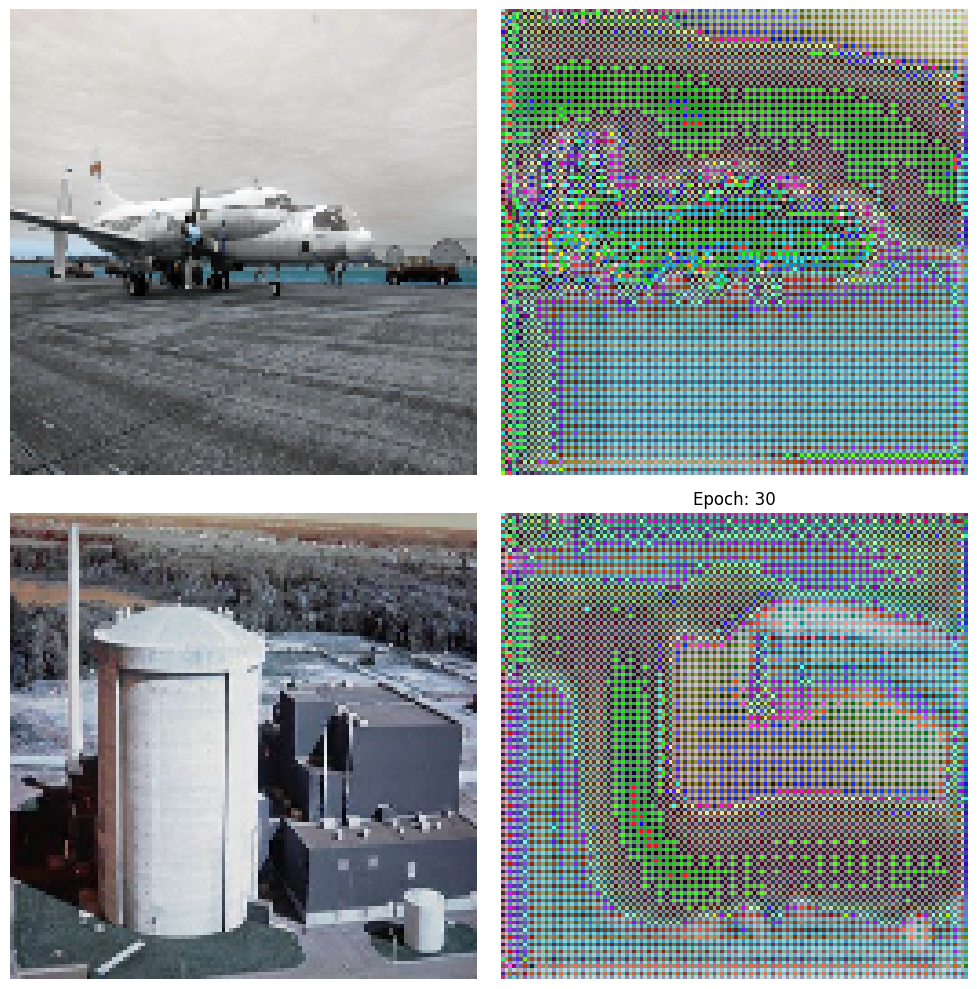

 10%|█         | 5/50 [12:30<1:33:57, 125.27s/it, Generator loss = 4.620400428771973 | Discriminator loss = 0.14501996338367462] 

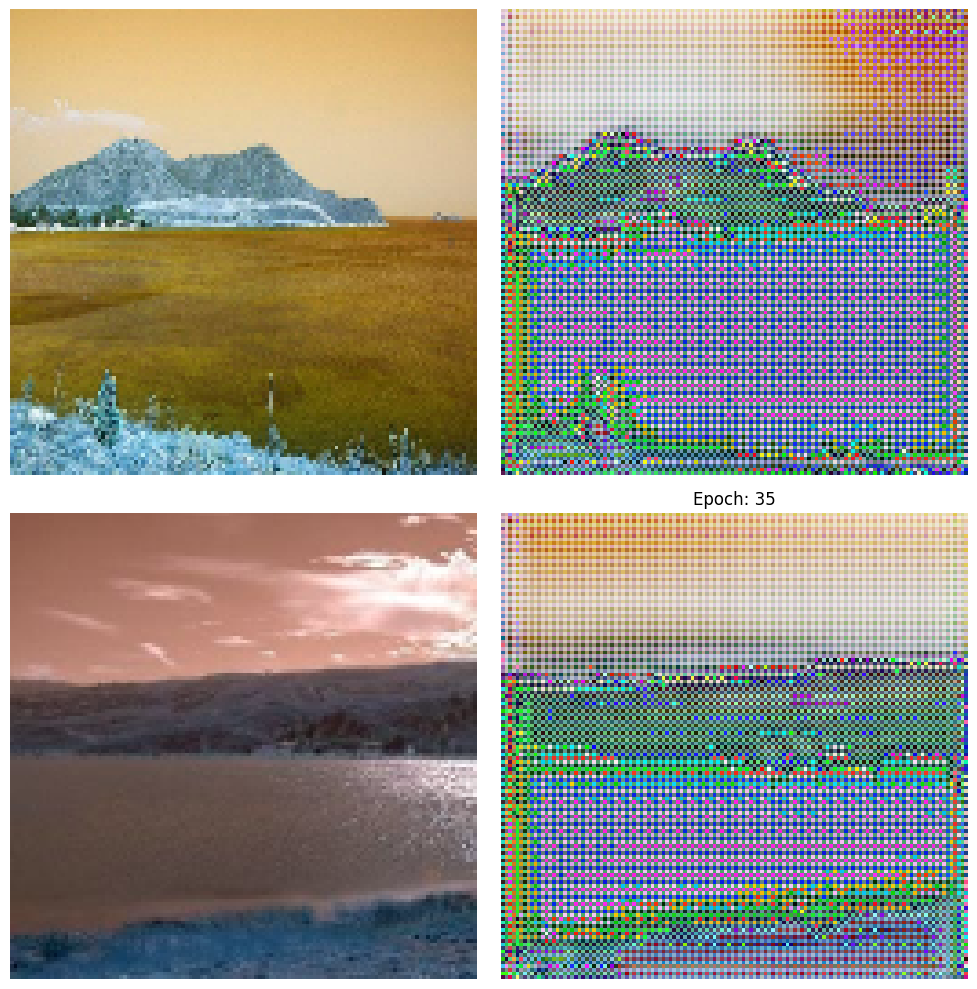

 20%|██        | 10/50 [22:56<1:23:27, 125.20s/it, Generator loss = 4.331790447235107 | Discriminator loss = 0.09224296361207962]  

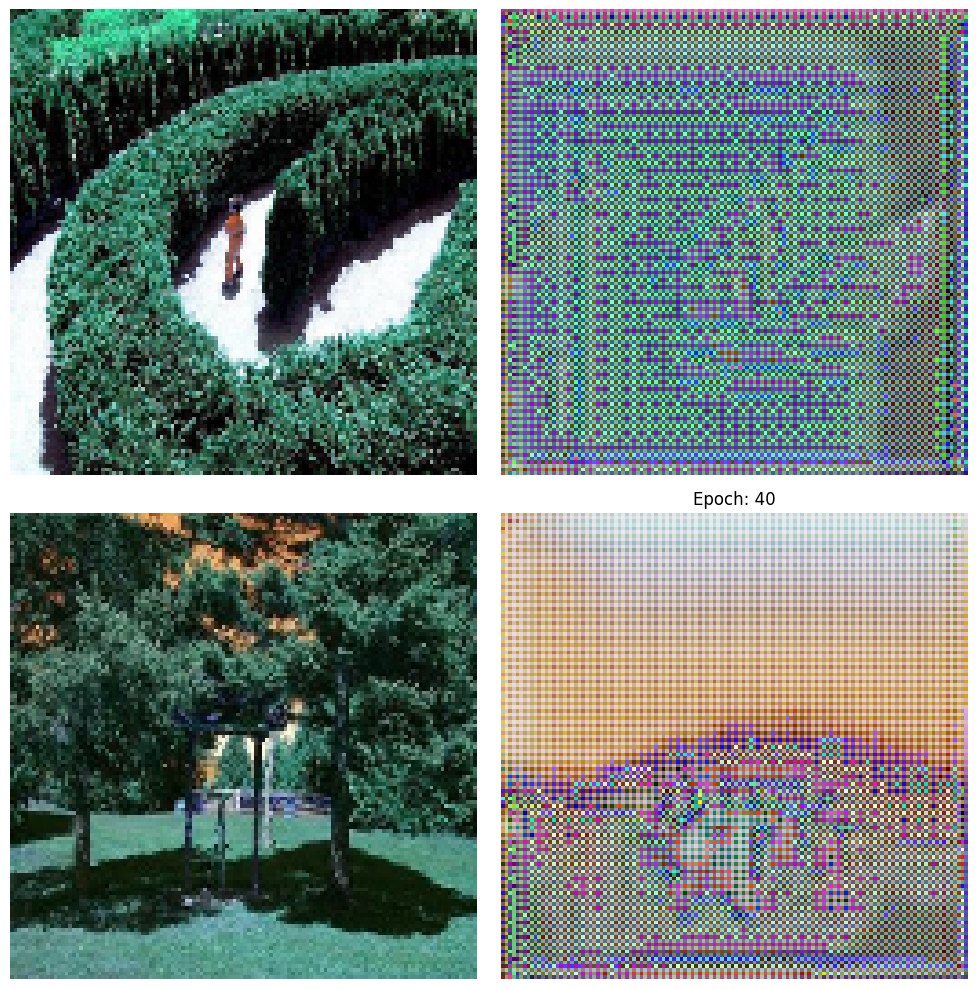

 30%|███       | 15/50 [33:23<1:13:02, 125.20s/it, Generator loss = 4.629546165466309 | Discriminator loss = 0.09754382818937302] 

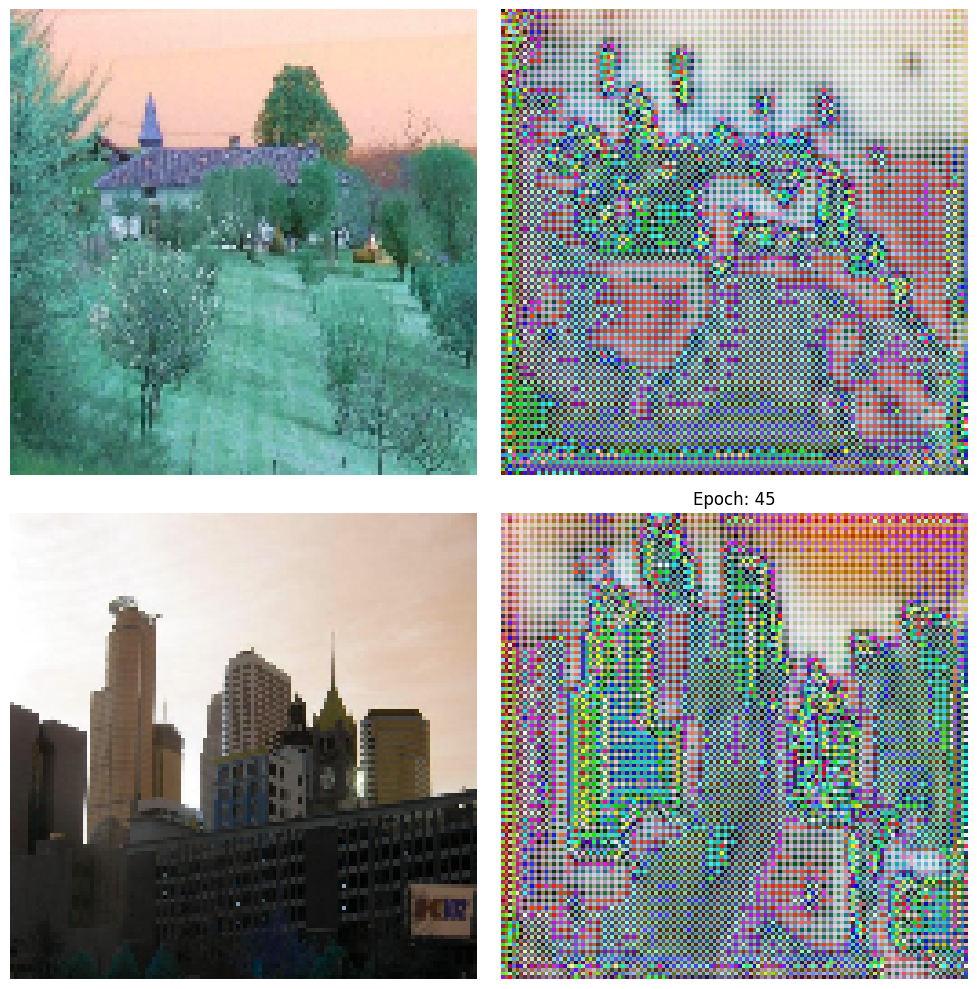

 40%|████      | 20/50 [43:49<1:02:36, 125.23s/it, Generator loss = 4.050029277801514 | Discriminator loss = 0.12232525646686554] 

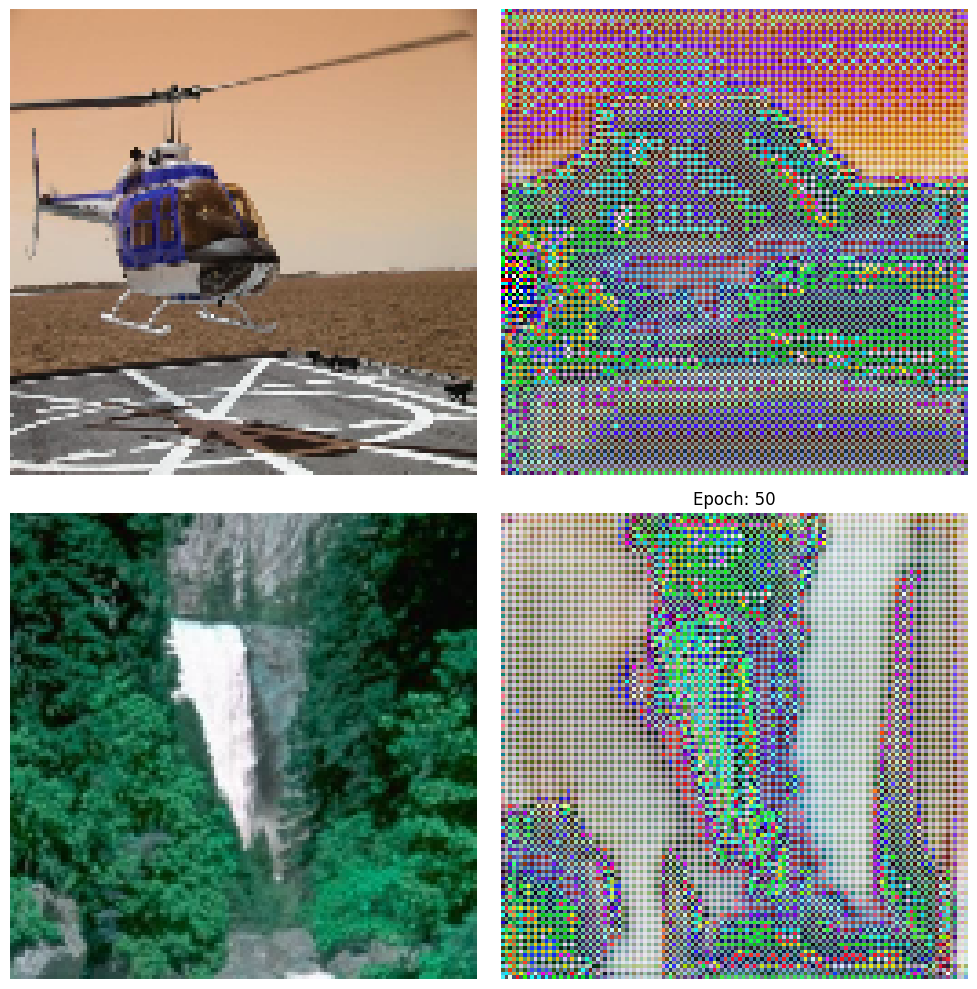

 50%|█████     | 25/50 [54:15<52:11, 125.26s/it, Generator loss = 4.064691066741943 | Discriminator loss = 0.11183319985866547]   

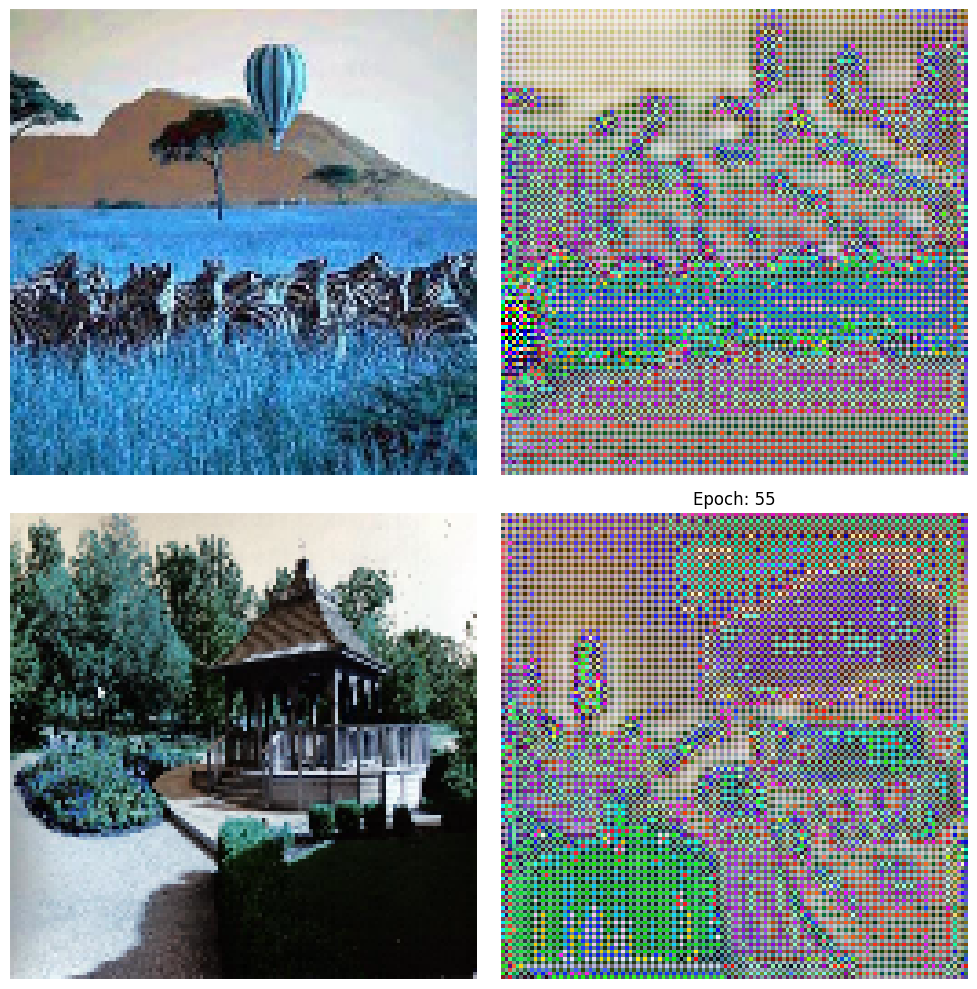

 60%|██████    | 30/50 [1:04:42<41:44, 125.24s/it, Generator loss = 4.057169437408447 | Discriminator loss = 0.11963259428739548] 

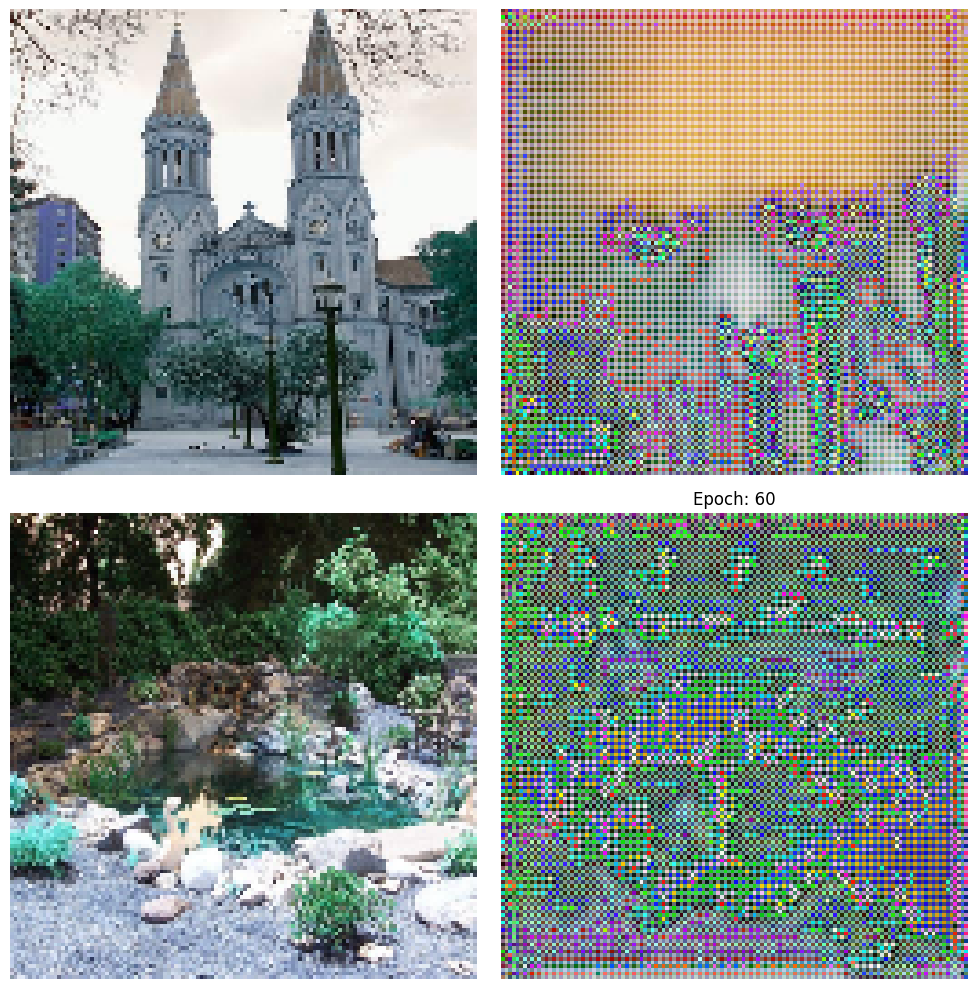

 70%|███████   | 35/50 [1:15:09<31:19, 125.30s/it, Generator loss = 4.072510719299316 | Discriminator loss = 0.11355094611644745]  

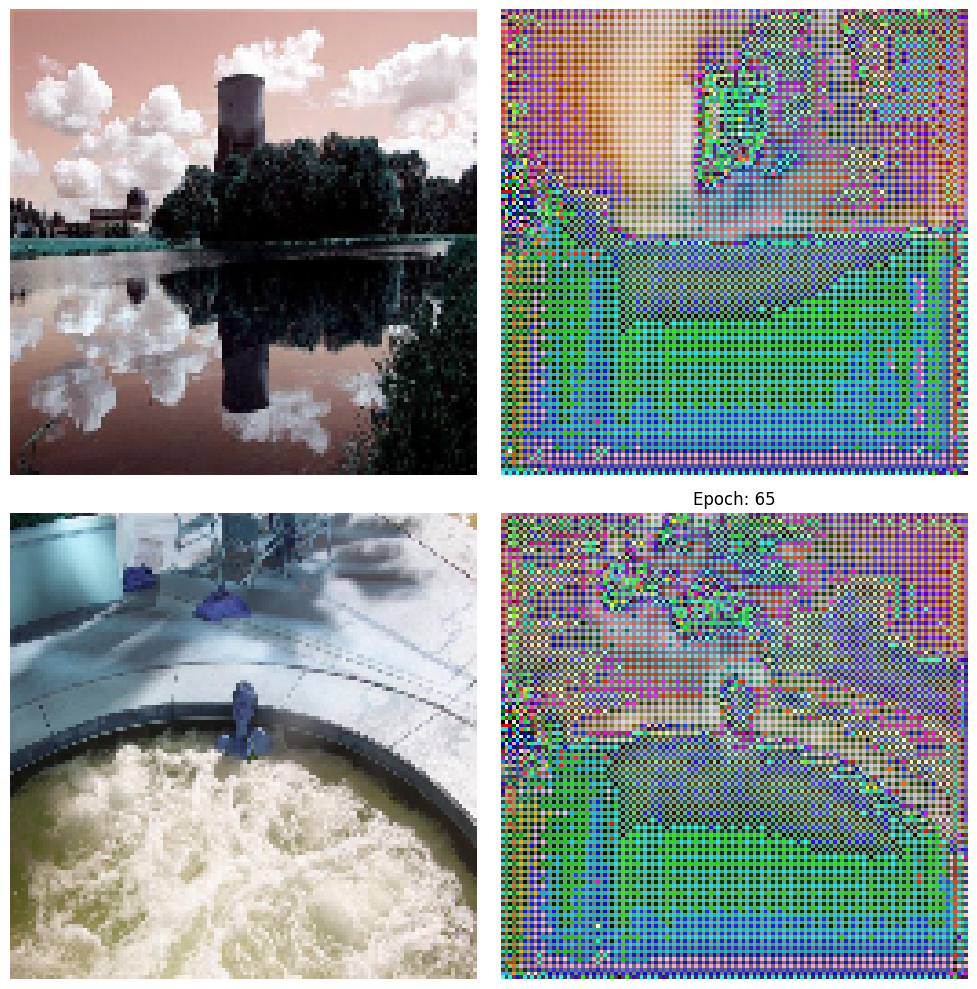

 80%|████████  | 40/50 [1:25:35<20:52, 125.30s/it, Generator loss = 4.3200364112854 | Discriminator loss = 0.090968057513237]     

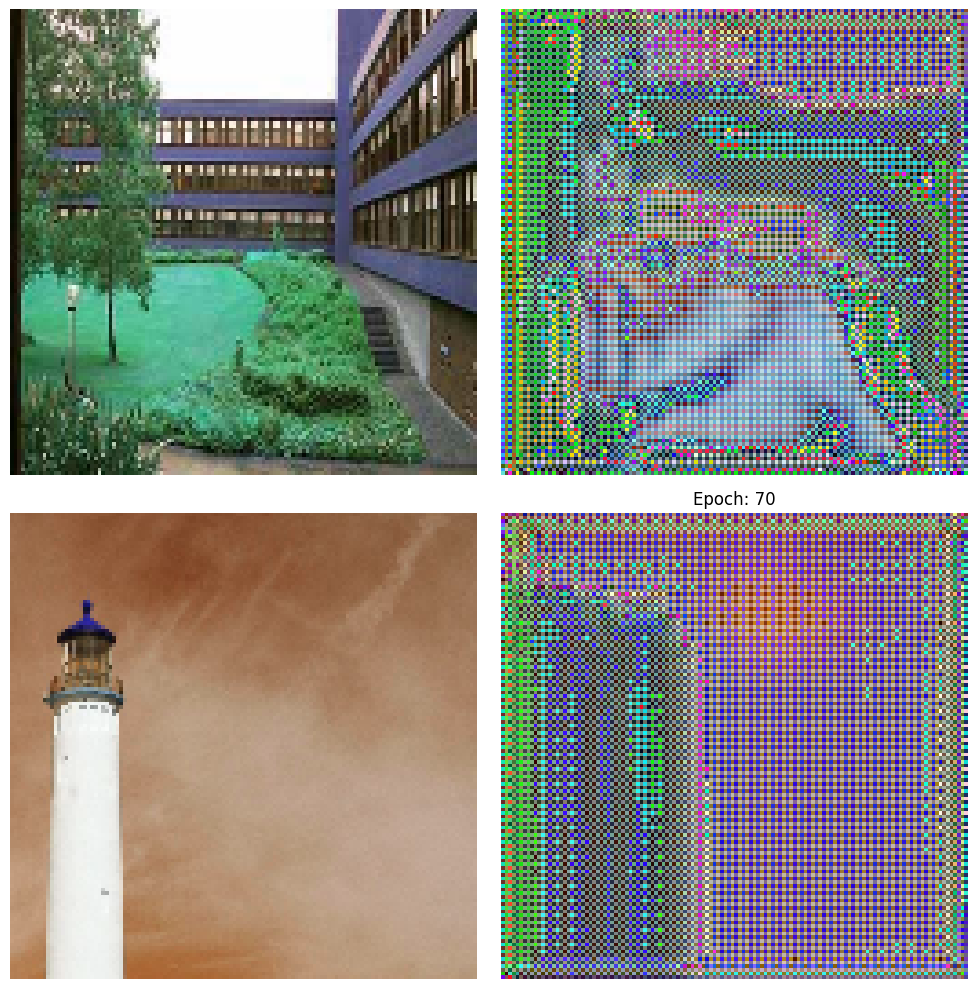

 90%|█████████ | 45/50 [1:36:02<10:26, 125.29s/it, Generator loss = 4.372934818267822 | Discriminator loss = 0.1053614690899849]   

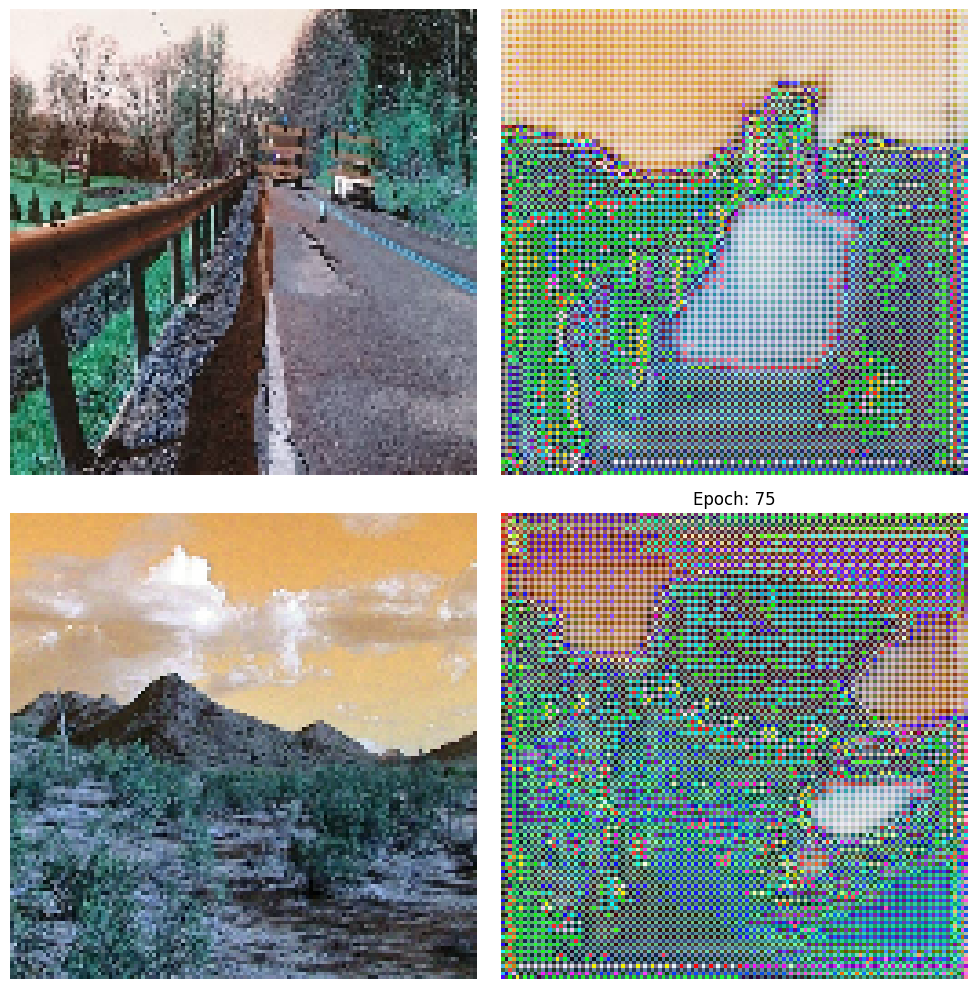

100%|██████████| 50/50 [1:44:24<00:00, 125.28s/it, Generator loss = 4.435549736022949 | Discriminator loss = 0.09650541841983795] 


In [15]:
new_epochs_num = 50
bar = tqdm(range(epochs_num, epochs_num + new_epochs_num))
for epoch in bar:
    epoch_loss_G = 0
    epoch_loss_D = 0
    count = 0
    for batch in data_loader:
        images, masks = batch
        images, masks = images.to('cuda'), masks.to('cuda')

        pred = model(masks, images)
        loss_D = (pred[1] + pred[2]) * 0.5
        loss_G = pred[0]
        
        epoch_loss_G += loss_G
        epoch_loss_D += loss_D
        count += 1

        model.optimizer_G.zero_grad()
        loss_G.backward()          
        model.optimizer_G.step()

        model.optimizer_D.zero_grad()
        loss_D.backward()        
        model.optimizer_D.step()
        
        if count % 10 == 0:
            bar.set_postfix_str(f"Generator loss = {epoch_loss_G / count} | Discriminator loss = {epoch_loss_D / count}")
            wandb.log({"generator_loss": loss_G, "discriminator_loss": loss_D})
    if epoch % 5 == 0:
        visualize_batch(images, model.inference(masks), epoch, size=2)
    wandb.log({"generator_epoch_loss": epoch_loss_G / count, "discriminator_epoch_loss": epoch_loss_G / count})

In [16]:
torch.save(model.state_dict(), './model')

In [17]:
image = Image.open('/kaggle/working/segmentuki/data/train_img/aachen_000000_000019_leftImg8bit.png')

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((128, 128))
])

img_tensor = transform(image).unsqueeze(0).float().to('cuda')
res = model.inference(img_tensor)

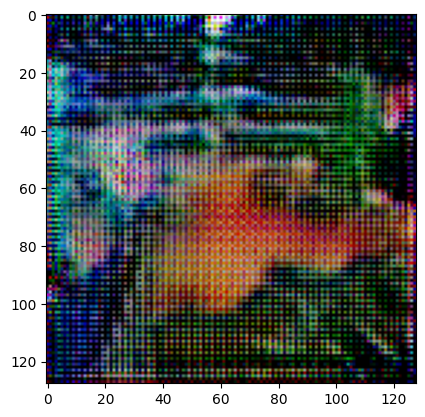

In [18]:
plt.imshow(res.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())

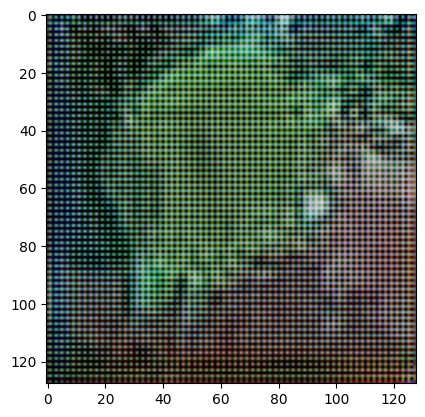

In [25]:
batch = next(iter(data_loader))
plt.imshow(model.inference(batch[1].to('cuda'))[0].squeeze(0).permute(1, 2, 0).cpu().detach().numpy())